# ZNEUS PROJEKT 2 - CNN (Animals-10)

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('/kaggle/input/animals10')
from PIL import Image
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.manifold import TSNE

2025-12-07 18:27:58.577988: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765132078.768202      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765132078.818599      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

## 1. EDA

First things first, we're going to pull up our data and label them, depending on the directory they are found in and place them inside a dataframe, so we can use them for later training.

The original names came in Italian, luckily the original poster of the dataset provided a python dictionary to translate the names. Bad news tho, the dictionary is incomplete (it lacks the spider column), so we had to modify it a little. We translate the names of the animals directly before labling and only keep the English labels.

In [2]:
# allow importing translate.py
sys.path.append('/kaggle/input/animals10')

#translate properly
translate = {
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "hen",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "ragno": "spider",
    "scoiattolo": "squirrel"
}

root = "/kaggle/input/animals10/raw-img"

data = []

for folder_name in os.listdir(root):
    folder_path = os.path.join(root, folder_name)
    if not os.path.isdir(folder_path):
        continue

    eng_label = translate.get(folder_name, folder_name)

    for file in os.listdir(folder_path):
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            data.append({
                "label": eng_label,
                "path": os.path.join(folder_path, file)
            })

df = pd.DataFrame(data)
df.head()


,label,path
0,horse,/kaggle/input/animals10/raw-img/cavallo/OIP-md...
1,horse,/kaggle/input/animals10/raw-img/cavallo/OIP-TP...
2,horse,/kaggle/input/animals10/raw-img/cavallo/OIP-jl...
3,horse,/kaggle/input/animals10/raw-img/cavallo/OIP-F4...
4,horse,/kaggle/input/animals10/raw-img/cavallo/OIP-UF...


In [3]:
heights = []
widths = []
file_types = []
color_modes = []

for path in df["path"]:
    try:
        with Image.open(path) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)
            file_types.append(os.path.splitext(path)[1].lower())
            color_modes.append(img.mode)
    except Exception as e:
        print(f"Error reading {path}: {e}")

df["width"] = widths
df["height"] = heights
df["file_type"] = file_types
df["color_mode"] = color_modes

In [4]:
print(f"Number of total images: {len(df)}")

Number of total images: 26179


<Axes: title={'center': 'Class Distribution'}, xlabel='label'>

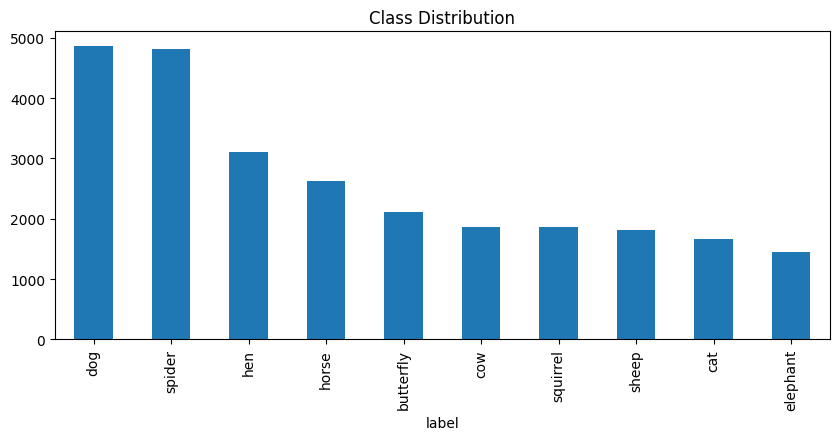

In [5]:
df["label"].value_counts().plot.bar(figsize=(10,4), title="Class Distribution")

As we can see, out of the 26 thousand images we have, most of it are pictures of dogs and spiders. This is great for dog lovers but awful for any arachnophobes. We'll need to balance out the data later but for now, let's look closer at the files themselves and their metadata.

In [6]:
df["file_type"].value_counts()

file_type
.jpeg    24209
.jpg      1919
.png        51
Name: count, dtype: int64

In [7]:
df["color_mode"].value_counts()

color_mode
RGB     26128
RGBA       49
CMYK        1
L           1
Name: count, dtype: int64

In [8]:
df.describe()[["width", "height"]]

,width,height
count,26179.000000,26179.000000
mean,320.038810,252.630162
std,196.935326,148.403298
min,60.000000,57.000000
25%,300.000000,200.000000
50%,300.000000,225.000000
75%,300.000000,300.000000
max,6720.000000,6000.000000


According to the data, the images don't follow a uniform file type, nor resolution. The file type doesn't really matter, when training a CNN, however we will need to pad, scale or cut up the images into a uniform resolution.

The image filter actually helps us, because we can train the CNN on more robust data, however we don' have much of them. We can later create artificial robustness in our data using augmentations.

## 2. Preprocessing

First we change all image colour channels into RGB:

In [9]:
df = df[df['color_mode'] == 'RGB']

In [10]:
print(df['color_mode'].value_counts())

color_mode
RGB    26128
Name: count, dtype: int64


During testing we have found out the model learns well enough with a smaller sample of images. We have decided to cap the number of images for each class to a maximum of 2000. This makes the model faster to learn, while not sacrifising accuracy and precission.


Original class distribution:
label
dog          4863
spider       4820
hen          3098
horse        2623
butterfly    2073
cow          1866
squirrel     1862
sheep        1820
cat          1667
elephant     1436
Name: count, dtype: int64

Balanced class distribution:
label
horse        2000
hen          2000
dog          2000
butterfly    2000
spider       2000
cow          1866
squirrel     1862
sheep        1820
cat          1667
elephant     1436
Name: count, dtype: int64


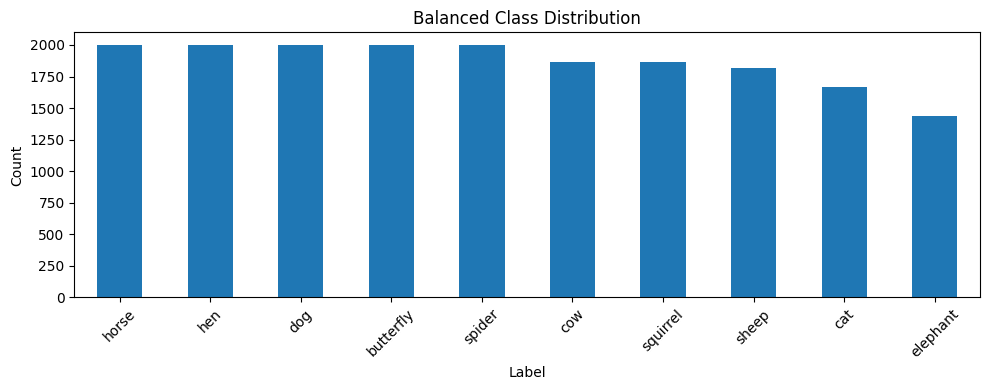

In [11]:
def balance_dataset(df, target_samples_per_class=2000, method='undersample'):
    balanced_dfs = []
    
    for label in df['label'].unique():
        class_df = df[df['label'] == label]
        n_samples = len(class_df)
        
        if method == 'undersample':
            # Undersample to target
            if n_samples > target_samples_per_class:
                class_df = resample(class_df, 
                                  n_samples=target_samples_per_class,
                                  random_state=42,
                                  replace=False)
        elif method == 'oversample':
            # Oversample to target
            if n_samples < target_samples_per_class:
                class_df = resample(class_df,
                                  n_samples=target_samples_per_class,
                                  random_state=42,
                                  replace=True)
        
        balanced_dfs.append(class_df)
    
    return pd.concat(balanced_dfs, ignore_index=True)

print("\nOriginal class distribution:")
print(df['label'].value_counts())

df_balanced = balance_dataset(df, target_samples_per_class=2000, method='undersample')

print("\nBalanced class distribution:")
print(df_balanced['label'].value_counts())

# Visualize balanced distribution
plt.figure(figsize=(10, 4))
df_balanced['label'].value_counts().plot.bar(title="Balanced Class Distribution")
plt.ylabel("Count")
plt.xlabel("Label")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [12]:
train_df, temp_df = train_test_split(
    df_balanced, 
    test_size=0.3, 
    stratify=df_balanced['label'],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=42
)

print(f"\nTrain size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")


Train size: 13055
Validation size: 2798
Test size: 2798


In [13]:
def check_loaded_images(generator, n_batches=3):
    print("\n" + "="*60)
    print("="*60)
    
    shapes = []
    dtypes = []
    value_ranges = []
    
    for i in range(n_batches):
        batch_images, batch_labels = next(generator)
        
        for img in batch_images:
            shapes.append(img.shape)
            dtypes.append(img.dtype)
            value_ranges.append((img.min(), img.max()))
    
    shapes = np.array(shapes)
    
    print(f"Checked {len(shapes)} images from generator")
    print(f"\nImage shapes: {np.unique(shapes, axis=0)}")
    print(f"Data types: {set(dtypes)}")
    print(f"Value range: min={min([r[0] for r in value_ranges]):.4f}, "
          f"max={max([r[1] for r in value_ranges]):.4f}")
    print(f"Expected: shape=(224, 224, 3), dtype=float32, range=[0.0, 1.0]")
    
    if all(shape[2] == 3 for shape in shapes):
        print("All images have RGB")
    else:
        print("WARNING: Some images are not RGB!")
    
    return shapes, dtypes, value_ranges


We want to add augmentations into the images to make the model more robust. We add a number of smaller augmentations to images, including:
- random scaling
- random shifting
- random flipping
- distortion

In [14]:
IMG_SIZE = (224, 224)  
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to [0,1]
    rotation_range=20,           # Randomly rotate images
    width_shift_range=0.2,       # Randomly shift images horizontally
    height_shift_range=0.2,      # Randomly shift images vertically
    horizontal_flip=True,        # Randomly flip images
    zoom_range=0.2,              # Randomly zoom images
    shear_range=0.2,             # Shear transformations
    fill_mode='nearest'          # Fill strategy for new pixels
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\nNumber of classes: {len(train_generator.class_indices)}")
print(f"Class indices: {train_generator.class_indices}")
print(f"Number of training batches: {len(train_generator)}")
print(f"Number of validation batches: {len(val_generator)}")
print(f"Number of test batches: {len(test_generator)}")

shapes, dtypes, value_ranges = check_loaded_images(train_generator, n_batches=3)

Found 13055 validated image filenames belonging to 10 classes.
Found 2798 validated image filenames belonging to 10 classes.
Found 2798 validated image filenames belonging to 10 classes.

Number of classes: 10
Class indices: {'butterfly': 0, 'cat': 1, 'cow': 2, 'dog': 3, 'elephant': 4, 'hen': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}
Number of training batches: 408
Number of validation batches: 88
Number of test batches: 88

Checked 96 images from generator

Image shapes: [[224 224   3]]
Data types: {dtype('float32')}
Value range: min=0.0000, max=1.0000
Expected: shape=(224, 224, 3), dtype=float32, range=[0.0, 1.0]
All images have RGB


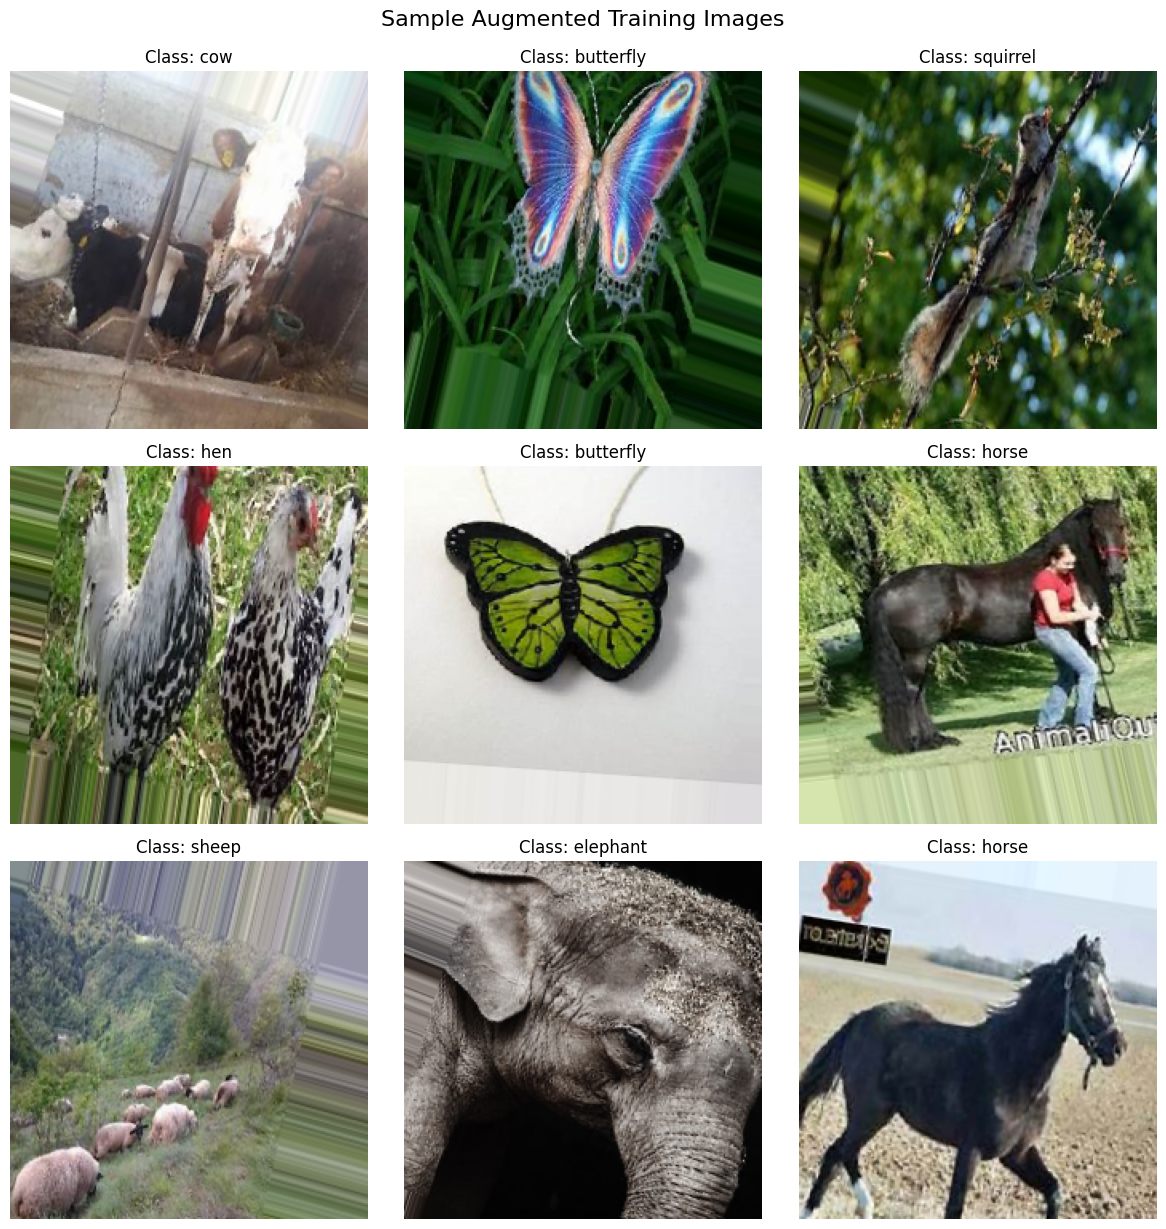

In [15]:
def visualize_augmentations(generator, n_images=9):
    images, labels = next(generator)
    
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.ravel()
    
    for i in range(min(n_images, len(images))):
        axes[i].imshow(images[i])
        axes[i].axis('off')
        # Get class name from label
        class_idx = np.argmax(labels[i])
        class_name = list(generator.class_indices.keys())[class_idx]
        axes[i].set_title(f"Class: {class_name}")
    
    plt.tight_layout()
    plt.suptitle("Sample Augmented Training Images", y=1.02, fontsize=16)
    plt.show()
visualize_augmentations(train_generator)

In [16]:
print(f"Target image size: {IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Target image size: (224, 224)
Batch size: 32
Training samples: 13055
Validation samples: 2798
Test samples: 2798


## 3. Model Training


Throughout testing, we tried multiple different models. First we down-scaled from 256x256 image input to 128x128, as advised by our lecturer. We noticed significant improvement in training time, while keeping the results satisfactory. 

Up next we tried if using only a maximum of 2000 images per class would hidner the laerning rate, however we didn't notice any over or undersampling. 

We also tested if Dropout layers would be able to help, however we eventually took them off, due to not having as good results as we had hoped. 

Lastly, we tested how a Global Average Pooling layer compared to a Dense/Flatten approach. After testing, we have decided to use GAV.

In [17]:
def create_simple_cnn(input_shape=(128, 128, 3), num_classes=10): #image size gets set here
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Fourth convolutional block
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Flatten and dense layers
        layers.GlobalAveragePooling2D(),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

In [18]:
NUM_CLASSES = len(train_generator.class_indices)
IMG_SHAPE = (224, 224, 3) #old code, we set-up the size in the model calling function as default parameters

model = create_simple_cnn(input_shape=IMG_SHAPE, num_classes=NUM_CLASSES)

print("MODEL ARCHITECTURE")
model.summary()

I0000 00:00:1765132268.299329      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765132268.300100      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


MODEL ARCHITECTURE


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 392,906 (1.50 MB)

 Trainable params: 391,946 (1.50 MB)

 Non-trainable params: 960 (3.75 KB)

In [19]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy', 
    metrics=['accuracy', 
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')]
)

In [28]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5, #cca 15% of # Epochs
    restore_best_weights=True,
    verbose=1
)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stop, reduce_lr]


In [21]:
print("TRAINING MODEL")

EPOCHS = 20

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

TRAINING MODEL


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1765132273.544653      98 service.cc:148] XLA service 0x78f6ac0075f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765132273.545407      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765132273.545426      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765132274.053602      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/408 ━━━━━━━━━━━━━━━━━━━━ 32s 81ms/step - accuracy: 0.1797 - loss: 2.5309 - precision: 0.3269 - recall: 0.0312   

I0000 00:00:1765132280.080976      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


408/408 ━━━━━━━━━━━━━━━━━━━━ 168s 388ms/step - accuracy: 0.2712 - loss: 2.0827 - precision: 0.5276 - recall: 0.0586 - val_accuracy: 0.1769 - val_loss: 2.3717 - val_precision: 0.2055 - val_recall: 0.0293 - learning_rate: 0.0010
Epoch 2/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 148s 363ms/step - accuracy: 0.4245 - loss: 1.6234 - precision: 0.6620 - recall: 0.1577 - val_accuracy: 0.4235 - val_loss: 1.7095 - val_precision: 0.5131 - val_recall: 0.2734 - learning_rate: 0.0010
Epoch 3/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 150s 368ms/step - accuracy: 0.5286 - loss: 1.3639 - precision: 0.7212 - recall: 0.3013 - val_accuracy: 0.4060 - val_loss: 1.9127 - val_precision: 0.4910 - val_recall: 0.2348 - learning_rate: 0.0010
Epoch 4/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 149s 364ms/step - accuracy: 0.5836 - loss: 1.2284 - precision: 0.7505 - recall: 0.3872 - val_accuracy: 0.2477 - val_loss: 5.8678 - val_precision: 0.2420 - val_recall: 0.2169 - learning_rate: 0.0010
Epoch 5/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 149s 365ms/step - a

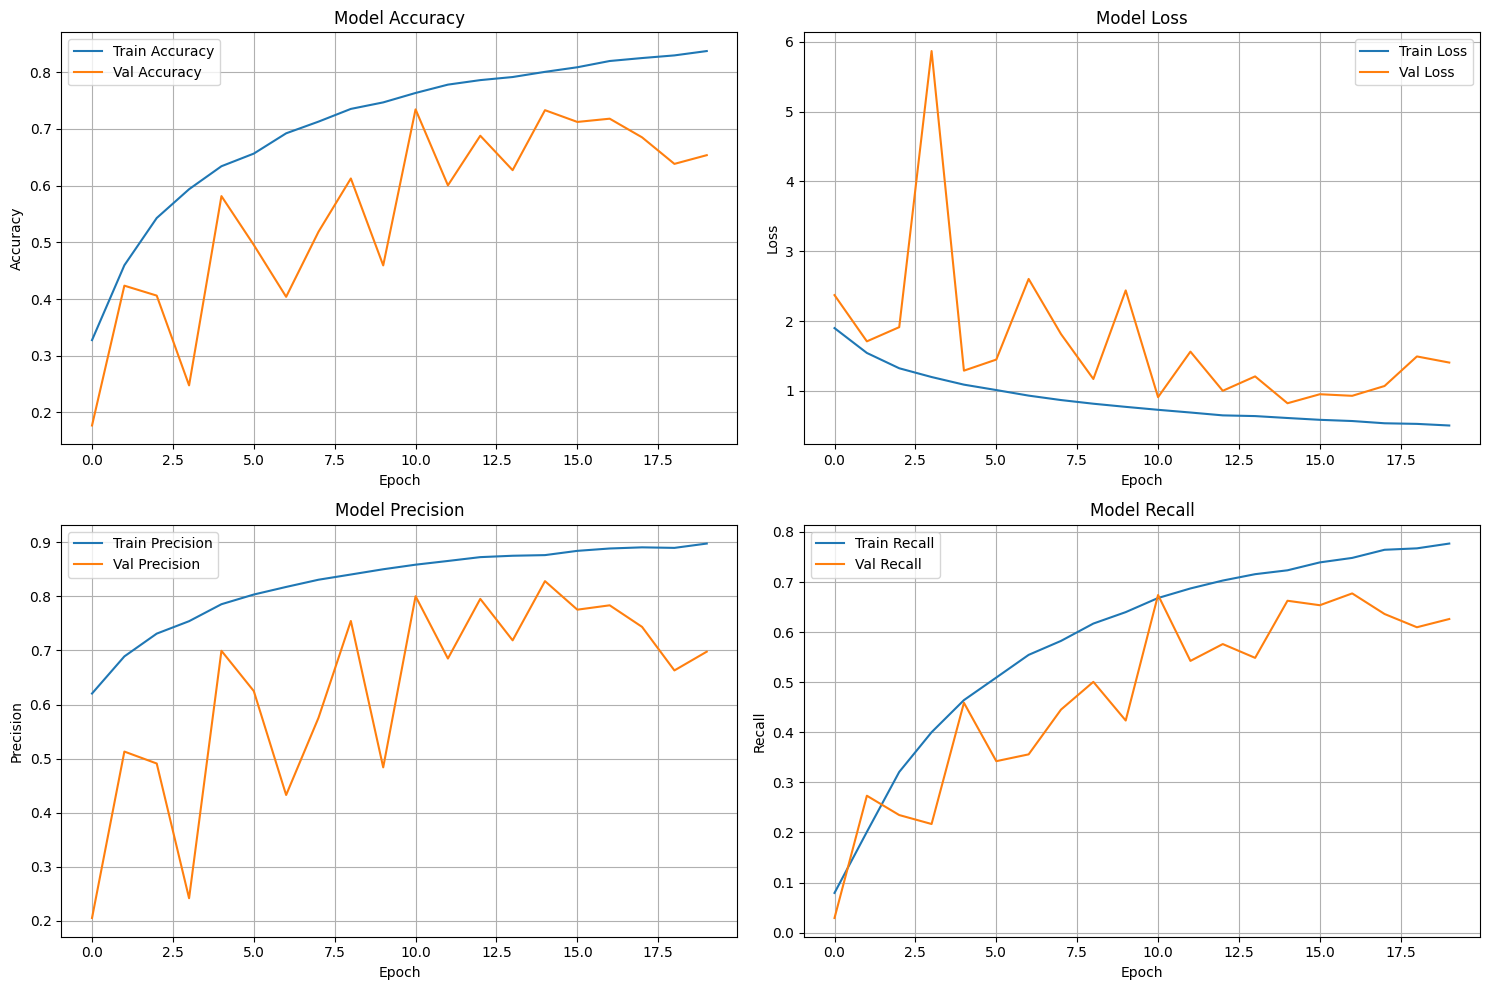

In [22]:
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Loss
    axes[0, 1].plot(history.history['loss'], label='Train Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Val Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Precision
    axes[1, 0].plot(history.history['precision'], label='Train Precision')
    axes[1, 0].plot(history.history['val_precision'], label='Val Precision')
    axes[1, 0].set_title('Model Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Recall
    axes[1, 1].plot(history.history['recall'], label='Train Recall')
    axes[1, 1].plot(history.history['val_recall'], label='Val Recall')
    axes[1, 1].set_title('Model Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
plot_training_history(history)


Generating predictions...
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step


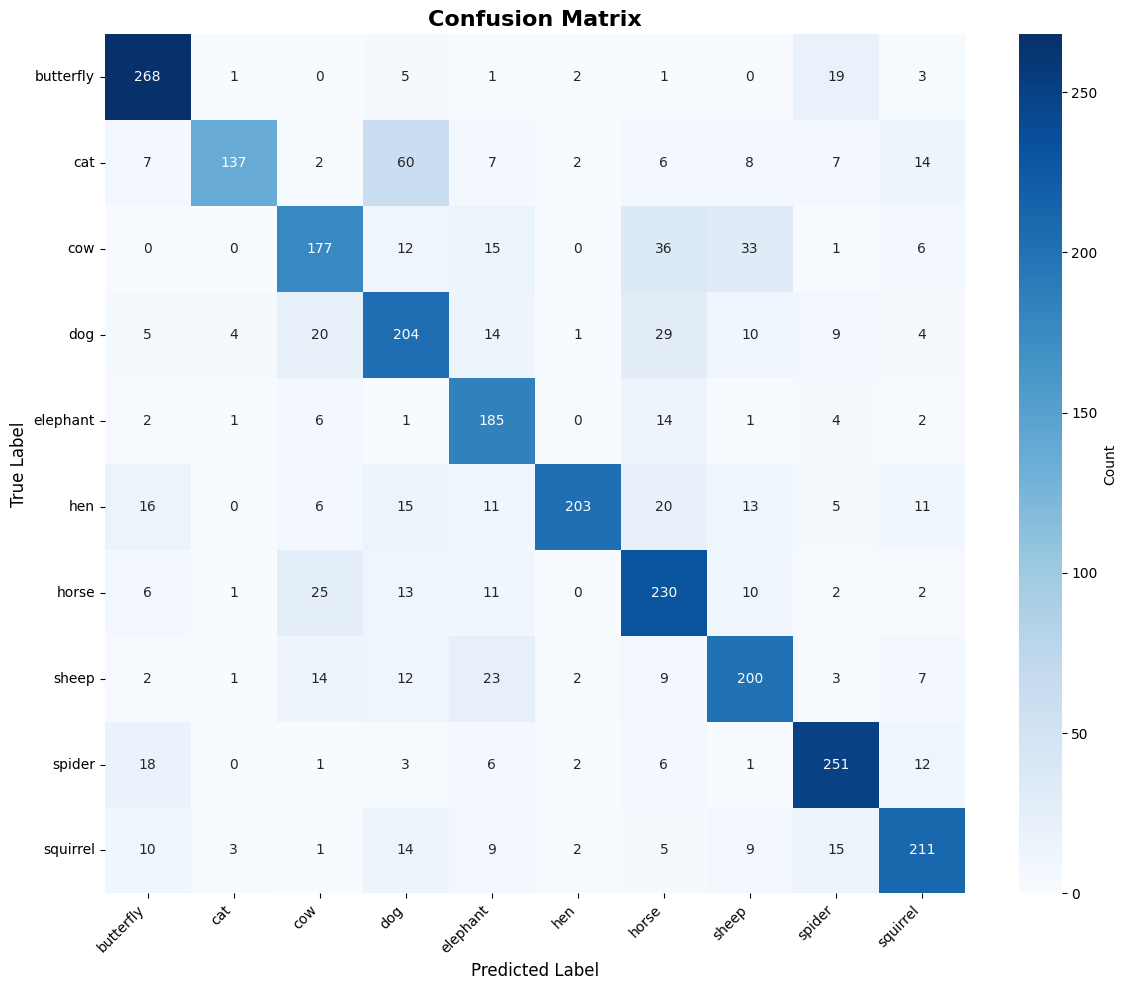

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get predictions
print("\nGenerating predictions...")
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Get class names
class_names = list(train_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## BONUS: t-SNE Visualization

For our bouns, we decided for a t-SNE visualization of our data. Using different colours for each class, we take the features from our last layers, transform them into a 2D vector and then plotting said vector. Each plot is color-coded to its respective label.

In [24]:
feature_extractor = keras.Model(
    inputs=model.inputs,
    outputs=model.layers[-2].output  #I love python arrays, in this case our GAV is the second to last layer, thus we use -2
)

print(f"Feature extractor output shape: {feature_extractor.output.shape}")

Feature extractor output shape: (None, 256)


In [25]:
features = []
labels = []

for images, label_batch in val_generator:
    feature_batch = feature_extractor.predict(images, verbose=0) #take the predicted labels
    features.append(feature_batch)
    labels.append(label_batch)

    #stop if validation done
    if len(features) * val_generator.batch_size >= len(val_generator.filenames):
        break

features = np.vstack(features) #get features (points)
labels = np.vstack(labels) #get labels
label_indices = np.argmax(labels, axis=1)
class_names = list(val_generator.class_indices.keys()) #get animals

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


In [26]:
#create a t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
features_2d = tsne.fit_transform(features) #transforms to 2D
colors = plt.cm.tab10(np.linspace(0, 1, 10)) #generated code for 10 random colours

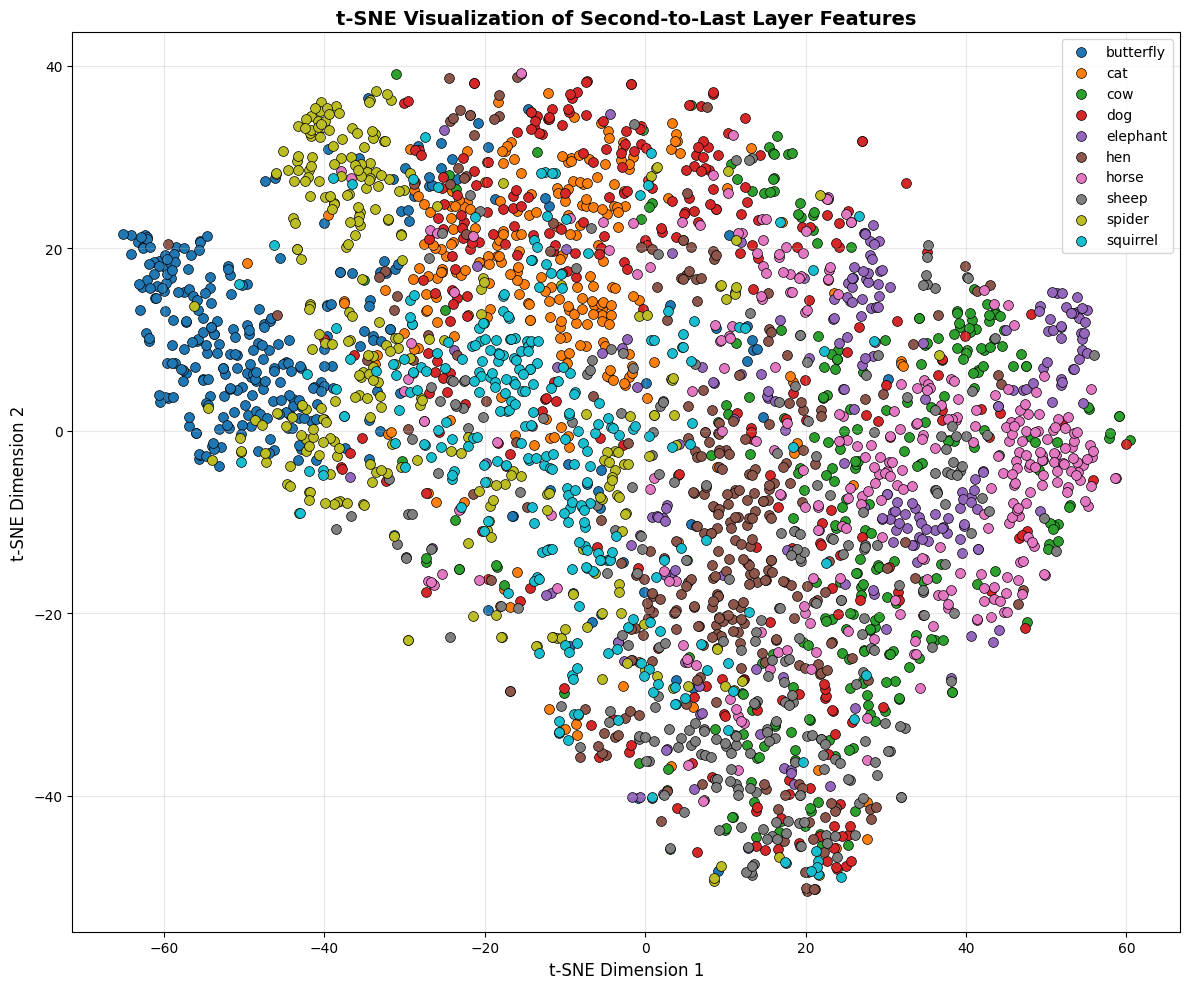

In [27]:
plt.figure(figsize=(12, 10))

for i, class_name in enumerate(class_names):
    mask = label_indices == i
    plt.scatter(
        features_2d[mask, 0],
        features_2d[mask, 1],
        c=[colors[i]],
        label=class_name,
        s=50,
        edgecolors='black',
        linewidth=0.5
    )

plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.title('t-SNE Visualization of Second-to-Last Layer Features', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()